In [36]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA, KernelPCA
from sklearn.datasets import make_circles
import data_manipulation as dm

Preparing toy data-set

In [28]:
b_name='Input_Background_1.csv'

background = np.genfromtxt(b_name, delimiter=',')
background = background[1:,:]
print("     .Background Loaded...")

s_name='Input_Signal_1.csv'

signal = np.genfromtxt(s_name, delimiter=',')
signal = signal[1:,:]
print("     .Signal Loaded...")

     .Background Loaded...
     .Signal Loaded...


In [40]:
background, _ = dm.divide(background, 100, 5000)
signal, _ = dm.divide(signal, 100, 500)

In [41]:
X = np.vstack((background,signal))
y = []
for i in range(len(background)):y.append(0)
for i in range(len(signal)):y.append(1)    

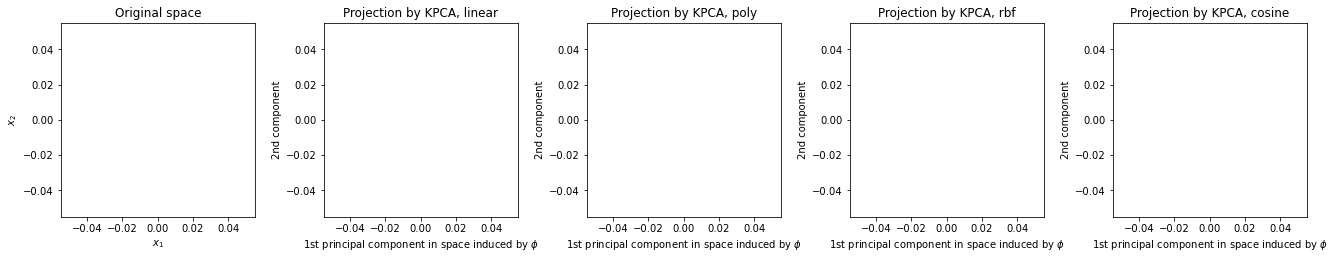

In [42]:
# training PCA for comparison 
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# definin loop structure for kernels
kernels = ['linear', 'poly', 'rbf', 'cosine']#'sigmoid', 'precomputed'


plt.figure(figsize=(int(len(kernels)*5)+2,5))
plt.subplot(1, int(len(kernels))+2, 1, aspect='equal')
plt.title("Original space")
reds = y == 0
blues = y == 1

plt.scatter(X[reds, 0], X[reds, 1], c="red",
            s=20, edgecolor='k')
plt.scatter(X[blues, 0], X[blues, 1], c="blue",
            s=20, edgecolor='k')
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")


for i,knl in enumerate(kernels):
    
    if knl in ['rbf', 'poly']:
        kpca = KernelPCA(kernel=knl, gamma=10, n_components=2)
    else:
        kpca = KernelPCA(kernel=knl, n_components=2)
        
    X_kpca = kpca.fit_transform(X)

    # Plot result

    plt.subplot(1, int(len(kernels))+2, i+2, aspect='equal')
    plt.scatter(X_kpca[reds, 0], X_kpca[reds, 1], c="red",
                s=20, edgecolor='k')
    plt.scatter(X_kpca[blues, 0], X_kpca[blues, 1], c="blue",
                s=20, edgecolor='k')
    plt.title("Projection by KPCA, " + knl)
    plt.xlabel(r"1st principal component in space induced by $\phi$")
    plt.ylabel("2nd component")

plt.tight_layout()
plt.show()